In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tempfile
import joblib

# 데이터 불러오기
data = pd.read_csv('../1. 행정동_상위변수_데이터/행정동_음주운전_합본_cp949.csv', encoding='cp949')

# Feature와 Target 분리
X = data.drop(columns=['읍면동', '음주운전 적발 건수'])
y = data['음주운전 적발 건수']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA 적용
pca = PCA(n_components=0.95, random_state=29)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# XGBoost 모델 설정
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=29)

# 하이퍼 파라미터 그리드 설정
param_grid = {
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0.5, 1, 2]
}

# 미리 C:\temp 폴더 생성 후 사용
temp_folder = tempfile.mkdtemp(dir="C:\\temp")

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Grid Search 학습 시, 임시 폴더 명시적으로 지정
with joblib.parallel_backend('loky', temp_folder=temp_folder):
    grid_search.fit(X_train_pca, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 예측 및 평가
y_pred = best_model.predict(X_test_pca)

# 평가 지표 계산
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 지표 출력
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"XGBoost MSE: {mse}")
print(f"XGBoost MAE: {mae}")
print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost R2 Score: {r2}")


Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
최적 하이퍼파라미터: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 1, 'lambda': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8}
XGBoost MSE: 0.557233863074655
XGBoost MAE: 0.5202214003966106
XGBoost RMSE: 0.746480986412015
XGBoost R2 Score: 0.9162074231680285


C:\Users\노준영\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


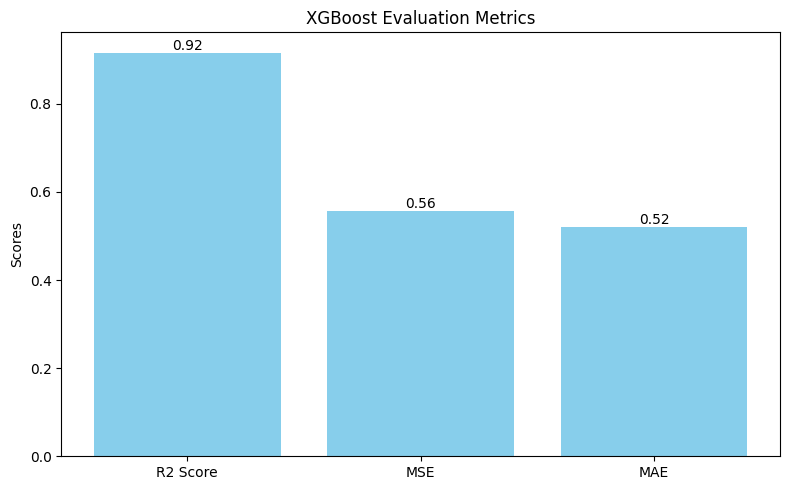

In [4]:
import matplotlib.pyplot as plt

# 평가 지표 시각화
metrics = ['R2 Score', 'MSE', 'MAE']
scores = [r2, mse, mae]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color='skyblue')

# 그래프 위에 값 출력
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.ylabel('Scores')
plt.title('XGBoost Evaluation Metrics')
plt.tight_layout()
plt.show()


In [4]:
# Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
# 최적 하이퍼파라미터: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 1, 'lambda': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8}
# XGBoost MSE: 0.557233863074655
# XGBoost MAE: 0.5202214003966106
# XGBoost RMSE: 0.746480986412015
# XGBoost R2 Score: 0.9162074231680285

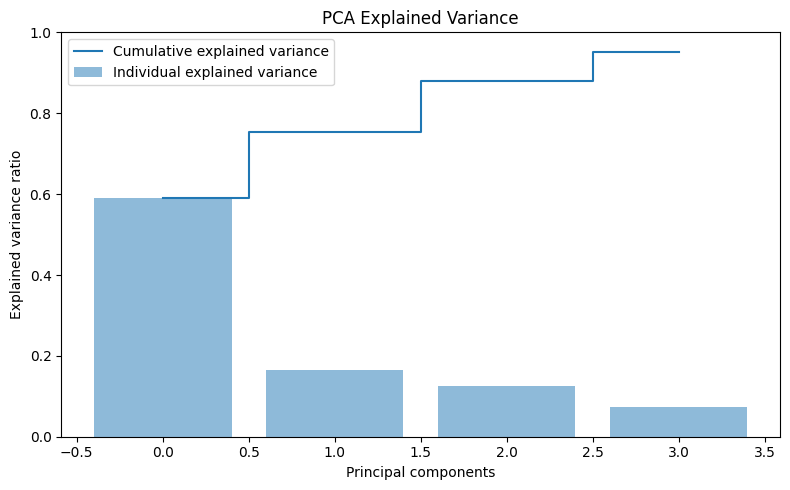

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 데이터 불러오기
data = pd.read_csv('../1. 행정동_상위변수_데이터/행정동_음주운전_합본_cp949.csv', encoding='cp949')

# Feature와 Target 분리
X = data.drop(columns=['읍면동', '음주운전 적발 건수'])
y = data['음주운전 적발 건수']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA 적용
pca = PCA(n_components=0.95, random_state=29)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# PCA 설명 분산 시각화
explained_variance_ratio = pca.explained_variance_ratio_
cum_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(len(cum_variance_ratio)), cum_variance_ratio, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [5]:
from joblib import dump, load

dump(pca, 'pca_model.joblib')
dump(scaler, 'scaler.joblib')

# 모델 저장
dump(best_model, 'xgb_model_best.joblib')
print("모델이 'xgb_model_best.joblib'에 저장되었습니다.")

# 모델 로드
xgb_loaded = load('xgb_model_best.joblib')
print("저장된 모델이 로드되었습니다.")


모델이 'xgb_model_best.joblib'에 저장되었습니다.
저장된 모델이 로드되었습니다.
